--- Ячейка 1: Загрузка 'чистых' данных... ---


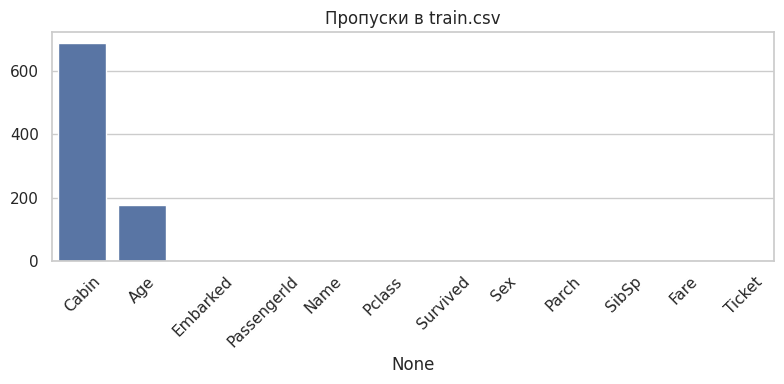

Размер Train: (891, 12)
Размер Test: (418, 11)


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler 

print("--- Ячейка 1: Загрузка 'чистых' данных... ---")
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# визуализация пропусков в train
missing = train_df.isna().sum().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=missing.index, y=missing.values)
plt.xticks(rotation=45)
plt.title("Пропуски в train.csv")
plt.tight_layout()
plt.show()


test_passenger_ids = test_df['PassengerId']

print(f"Размер Train: {train_df.shape}")
print(f"Размер Test: {test_df.shape}")



In [2]:
# ПРЕДОБРАБОТКА 
print("\n--- Ячейка 2: Запуск 'ЧЕМПИОНСКОГО' блока предобработки... ---")

# объединяем, чтобы обработка была одинаковой
full_df = pd.concat([train_df.drop('Survived', axis=1), test_df], axis=0, sort=False).reset_index(drop=True)

# 1. Title
full_df['Title'] = full_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
full_df['Title'] = full_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
full_df['Title'] = full_df['Title'].replace('Mme', 'Mrs')
rare_titles = ['Dr','Rev','Col','Major','Don','Lady','Sir','Capt','Countess','Jonkheer','Dona']
full_df['Title'] = full_df['Title'].replace(rare_titles, 'Rare')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
full_df['Title'] = full_df['Title'].map(title_mapping).fillna(0)

# 2. FamilySize / IsAlone
full_df['FamilySize'] = full_df['SibSp'] + full_df['Parch'] + 1
full_df['IsAlone'] = (full_df['FamilySize'] == 1).astype(int)

# 3. HasCabin 
full_df['HasCabin'] = full_df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

# 4. Заполнение Embarked
full_df['Embarked'] = full_df['Embarked'].fillna(full_df['Embarked'].mode()[0])

# 5. Sex -> 0/1
full_df['Sex'] = full_df['Sex'].map({'male': 0, 'female': 1}).astype(int)

# 6. Age и Fare — ЧУТЬ умнее
# Age по Pclass+Sex
full_df['Age'] = full_df.groupby(['Pclass', 'Sex'])['Age'].transform(
    lambda x: x.fillna(x.median())
)

# Fare по Pclass (если вдруг есть NaN)
full_df['Fare'] = full_df.groupby('Pclass')['Fare'].transform(
    lambda x: x.fillna(x.median())
)

# 7. Embarked в dummies
full_df = pd.get_dummies(full_df, columns=['Embarked'], drop_first=True)

# 8. Доп. фича: FarePerPerson 
full_df['FarePerPerson'] = full_df['Fare'] / full_df['FamilySize']

# 9. Удаляем мусор
full_df = full_df.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'])

print("\n--- ПРЕДОБРАБОТКА ЗАВЕРШЕНА ---")




--- Ячейка 2: Запуск 'ЧЕМПИОНСКОГО' блока предобработки... ---

--- ПРЕДОБРАБОТКА ЗАВЕРШЕНА ---



--- Ячейка 3: Обучение RandomForest ---
Данные отмасштабированы.
Модель обучена.


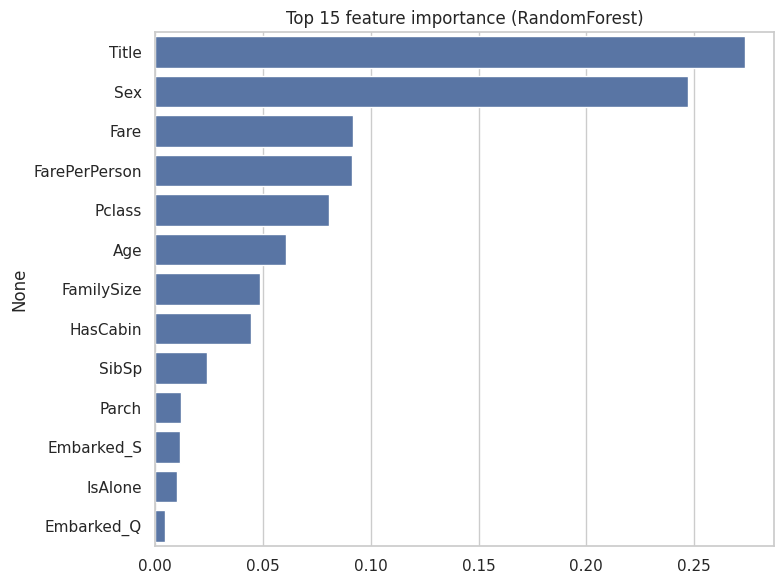

Train accuracy: 0.8574635241301908

--- Файл submission_V12_CHAMPION_tuned.csv СОЗДАН ---
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


In [3]:
 # МОДЕЛЬ и ОТПРАВКА 
print("\n--- Ячейка 3: Обучение RandomForest ---")

# делим назад
X_train = full_df.iloc[:len(train_df)]
X_test = full_df.iloc[len(train_df):]
y_train = train_df['Survived']

# скейлинг (neobjazatelnii blok)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Данные отмасштабированы.")

# модель —  деревьев чуть больше ,было 500
model = RandomForestClassifier(
    n_estimators=700,   
    max_depth=5,
    min_samples_leaf=3,
    min_samples_split=2,
    random_state=1,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)
print("Модель обучена.")

# важность признаков
importances = model.feature_importances_
feat_names = X_train.columns  # важные: до скейлера, поэтому X_train
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=fi.values[:15], y=fi.index[:15])
plt.title("Top 15 feature importance (RandomForest)")
plt.tight_layout()
plt.show()


print("Train accuracy:", model.score(X_train_scaled, y_train))

# предсказание
predictions = model.predict(X_test_scaled).astype(int)

submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': predictions
})
submission.to_csv('submission_V12_CHAMPION_tuned.csv', index=False)
print("\n--- Файл submission_V12_CHAMPION_tuned.csv СОЗДАН ---")
print(submission.head())
